In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks, resection_grid_results

plt.style.use('/om2/user/eisenaj/code/UniversalUnconsciousness/sci_style.mplstyle')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
with initialize(version_base="1.3", config_path="../../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class)) if f.endswith('.mat')]
session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]

# session_list = [session_list[1]]
# session_list = [session_list[2]]
# session_list = ['SPOCK_Ketamine_20210712', 'PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220203']
# session_list = ['PEDRI_Ketamine_20220113']

In [5]:
# areas = ['vlPFC', 'dlPFC', '-R', '-L']
areas = ['all']

## PCA

In [6]:
if cfg.params.pca:
    pca_chosen = {}
    for session in session_list:
        section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
        
        print("-"*20)
        print(f"SESSION = {session}")
        print("-"*20)
    
        normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
        filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    
        pca_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, "PCA_info", session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}")
        os.makedirs(pca_dir, exist_ok=True)
    
        pca_chosen[session] = {}
        for area in areas:
    
            # Get the relevant indices for each area
            os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
            variables = ['electrodeInfo']
            session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
            electrode_info = session_vars['electrodeInfo']
    
            if area == 'all':
                dimension_inds = np.arange(len(electrode_info['area']))
            else:
                # dimension_inds = np.where(electrode_info['area'] == area)[0]
                dimension_inds = np.where([area in area_entry for area_entry in electrode_info['area']])[0]
    
            # Get PCA explained variance ratios
            area_pca_file = os.path.join(pca_dir, area)
            if os.path.exists(area_pca_file):
                print(f"Found PCA info for {session}: {area}")
                pca_explained_variance_ratios = pd.read_pickle(area_pca_file)
            else:
                print(f"Computing PCA info for {session}: {area}")
                grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)
    
                directory = pd.read_pickle(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, f"{session}_lfp_chunked_20s", "directory"))
            
                pca_explained_variance_ratios = {}
                for t in tqdm(grid_search_window_start_ts, desc=f'Doing PCA for {session}: {area}'):
                    lfp = load_window_from_chunks(t, t + cfg.params.window, directory=directory, dimension_inds=dimension_inds)
                    lfp = lfp[::cfg.params.subsample]
                    # filter
                    pca = PCA(n_components=lfp.shape[1]).fit(lfp)
                    pca_explained_variance_ratios[t] = pca.explained_variance_ratio_
    
                pd.to_pickle(pca_explained_variance_ratios, area_pca_file)
    
            # pick the max number of PCs across windows greater than the threshold
            pca_chosen[session][area] = np.max([np.argmax(np.cumsum(evr) >= cfg.params.pca_thresh) for evr in pca_explained_variance_ratios.values()])
else:
    pca_chosen = None

# Collect Indices to Run

In [7]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)
    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'

    grid_search_run_list = get_grid_search_run_list(session, os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class), cfg.params.all_data_dir, cfg.params.window, cfg.grid_sets[cfg.params.grid_set], cfg.params.grid_set, grid_search_window_start_ts, cfg.params.T_pred, group_ranks=cfg.params.group_ranks, verbose=True, random_state=cfg.params.random_state)

    for area in areas:
        
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, 'grid_search_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)

        
        if not cfg.params.group_ranks:
            # filter runs for those with valid rank
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                if cfg.params.pca:
                    n_dims = pca_chosen[session][area]
                else:
                    n_dims = len(run_info['dimension_inds'])
                    if run_info['n_delays']*n_dims >= run_info['rank']:
                        run_info['run_index'] = run_index
                        filtered_run_list.append(run_info)
        else: # runs don't need to be filtered
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                run_info['run_index'] = run_index
                filtered_run_list.append(run_info)
        
        indices_to_run = []
        for run_info in filtered_run_list:
            filename = f"run_index-{run_info['run_index']}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_info['run_index'])
    
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(filtered_run_list):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = SPOCK_Ketamine_20210802
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220224
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220228
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210907
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210907 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210826
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210826 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220126
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220126 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210707
--------------------
*COMPLETE*: All results completed for SPOCK_Keta

# Running

In [8]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [9]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            else:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data: 0it [00:00, ?it/s]

# Collect Grid Search Results

In [10]:
cfg.params.stat_to_use = 'aic'

In [11]:
grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen)

In [12]:
sections_to_use = ['awake oddball', 'unconscious oddball', 'recovery oddball']
grid_search_results = resection_grid_results(cfg, grid_search_results, sections_to_use)

In [13]:
session = session_list[4]
area = areas[0]

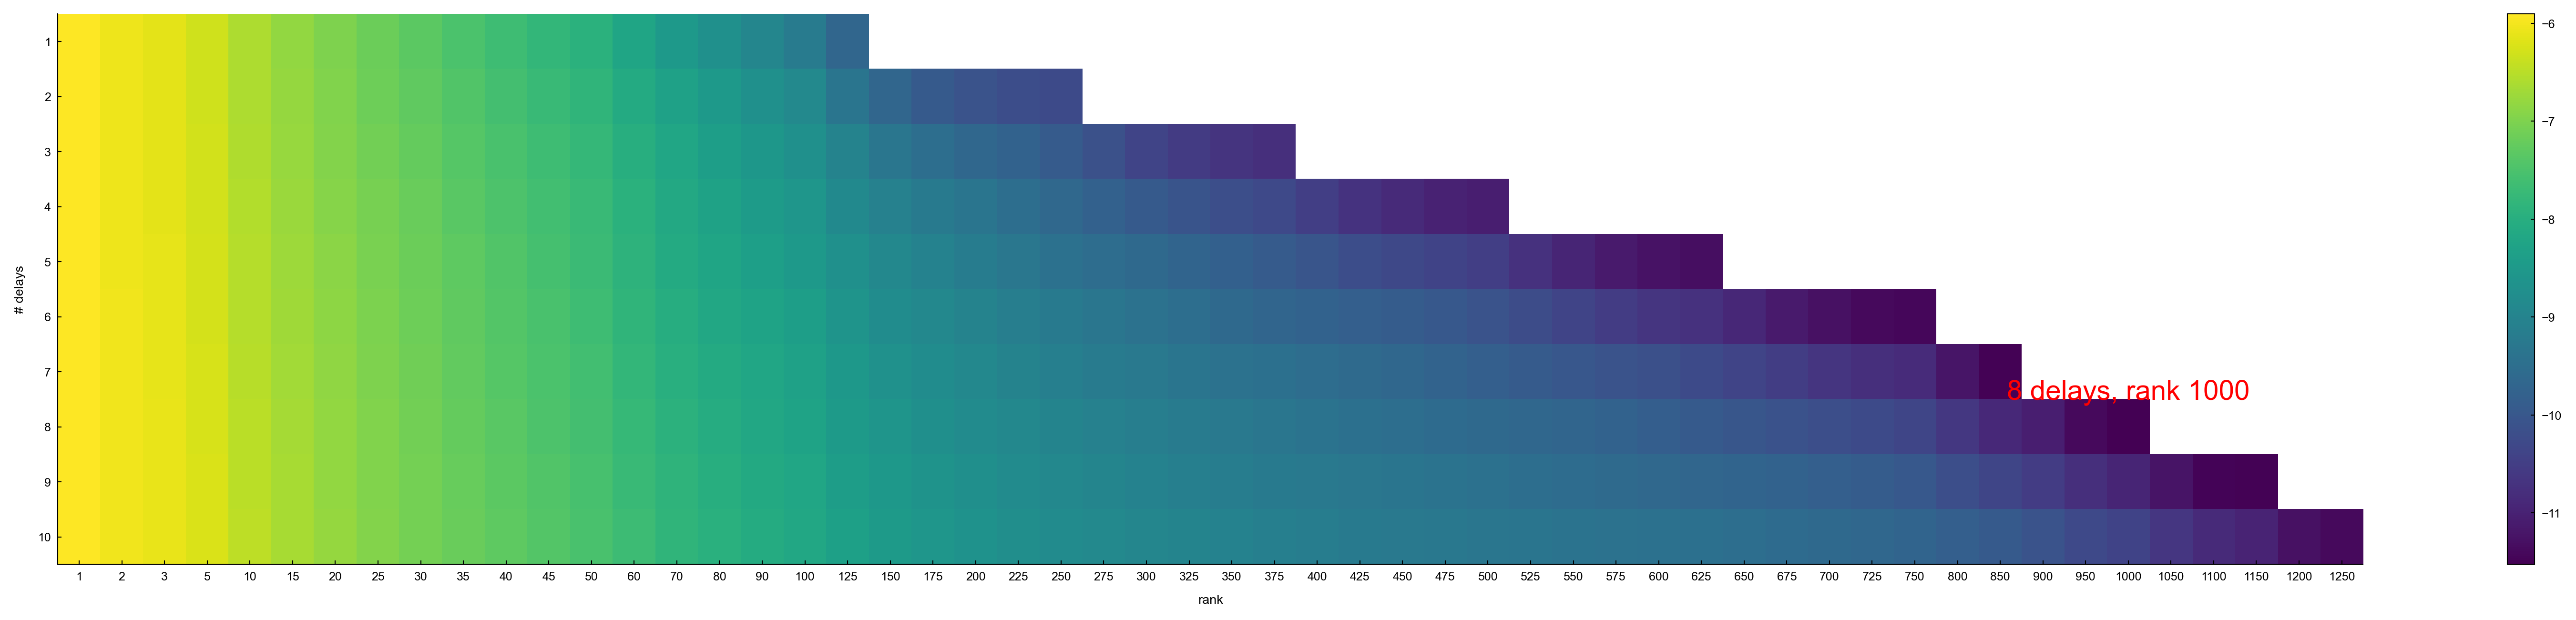

In [14]:
plt.figure(figsize=(26, 5))

n_ranks = np.argmax(np.isnan(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][0, -1]))
results_to_show = deepcopy(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][:, :, :n_ranks])
# results_to_show[results_to_show == 0] = np.nan

im = plt.imshow(results_to_show.mean(axis=0), aspect='auto')
i, j = grid_search_results[session][area]['i'], grid_search_results[session][area]['j']
plt.scatter(j, i, c='r')
n_delays = grid_search_results[session][area]['n_delays']
rank = grid_search_results[session][area]['rank']
plt.text(j, i - 0.5, f"{n_delays} delays, rank {rank}", c='r', ha='center', fontsize=14)
plt.xticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].rank_vals))[:n_ranks], cfg.grid_sets[cfg.params.grid_set].rank_vals[:n_ranks])
plt.yticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].n_delays_vals)), cfg.grid_sets[cfg.params.grid_set].n_delays_vals)
plt.ylabel('# delays')
plt.xlabel('rank')
plt.colorbar(im)
plt.show()

In [15]:
# base_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/leverOddball/delase_results"
# for session in os.listdir(base_dir):
#     working_dir = base_dir
    
#     while 'STAT_TO_USE' not in os.path.basename(working_dir):
#         working_dir = os.path.join(working_dir, os.listdir(working_dir)[0])

#     os.chdir(working_dir)
#     os.makedirs('SECTIONS_TO_USE_all_sections', exist_ok=True)
#     os.system("mv * SECTIONS_TO_USE_all_sections")

In [16]:
# base_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/leverOddball/delase_run_lists"
# os.chdir(base_dir)
# for f in os.listdir(base_dir):
#     os.system(f"mv {f} {f+'__SECTIONS_TO_USE_all_sections'}")
#     # os.system(f"mv {f} {f.split('__')[0]}")

# Get DeLASE Run List

In [17]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    delase_run_list = get_delase_run_list(cfg, session)

    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    sections_to_use_folder = 'SECTIONS_TO_USE_' + '__'.join(['_'.join(section.split(' ')) for section in cfg.params.sections_to_use])

    for area in areas:
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.delase_results_dir, cfg.params.data_class, 'delase_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, f"STAT_TO_USE_{cfg.params.stat_to_use}", sections_to_use_folder, f"STRIDE_{cfg.params.stride}", area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)
        indices_to_run = []
        for run_index in range(len(delase_run_list[area])):
            filename = f"run_index-{run_index}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_index)
        
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(delase_run_list[area]):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = SPOCK_Ketamine_20210802
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220224
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220228
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210907
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210907 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210826
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210826 - all!!
--------------------
SESSION = PEDRI_Ketamine_20220126
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220126 - all!!
--------------------
SESSION = SPOCK_Ketamine_20210707
--------------------
*COMPLETE*: All results completed for SPOCK_Keta

### Run

In [18]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [19]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.n_delays={int(grid_search_results[session][area]['n_delays'])} ++params.rank={int(grid_search_results[session][area]['rank'])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            else:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase.py -m ++params.session={session} ++params.area={area} ++params.n_delays={int(grid_search_results[session][area]['n_delays'])} ++params.rank={int(grid_search_results[session][area]['rank'])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data: 0it [00:00, ?it/s]

# Collect DeLASE Results

In [20]:
delase_results = get_delase_results(cfg, session_list, areas, pca_chosen)

In [21]:
session_infos = {}
section_infos = {}
for session in tqdm(session_list):
    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
    session_info = session_vars['sessionInfo']
    session_infos[session] = session_info

    section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    section_infos[session] = section_info

  0%|          | 0/30 [00:00<?, ?it/s]

In [22]:
session_lists = {'Spock': {}, 'Pedri': {}}
for session, session_info in session_infos.items():
    if 'SPOCK' in session:
        monkey = 'Spock'
    else:
        monkey = 'Pedri'
    
    if session_info['dose'] == 1.0:
        dose = 'low'
    else:
        dose = 'high'

    if dose in session_lists[monkey].keys():
        session_lists[monkey][dose].append(session)
    else:
        session_lists[monkey][dose] = [session]

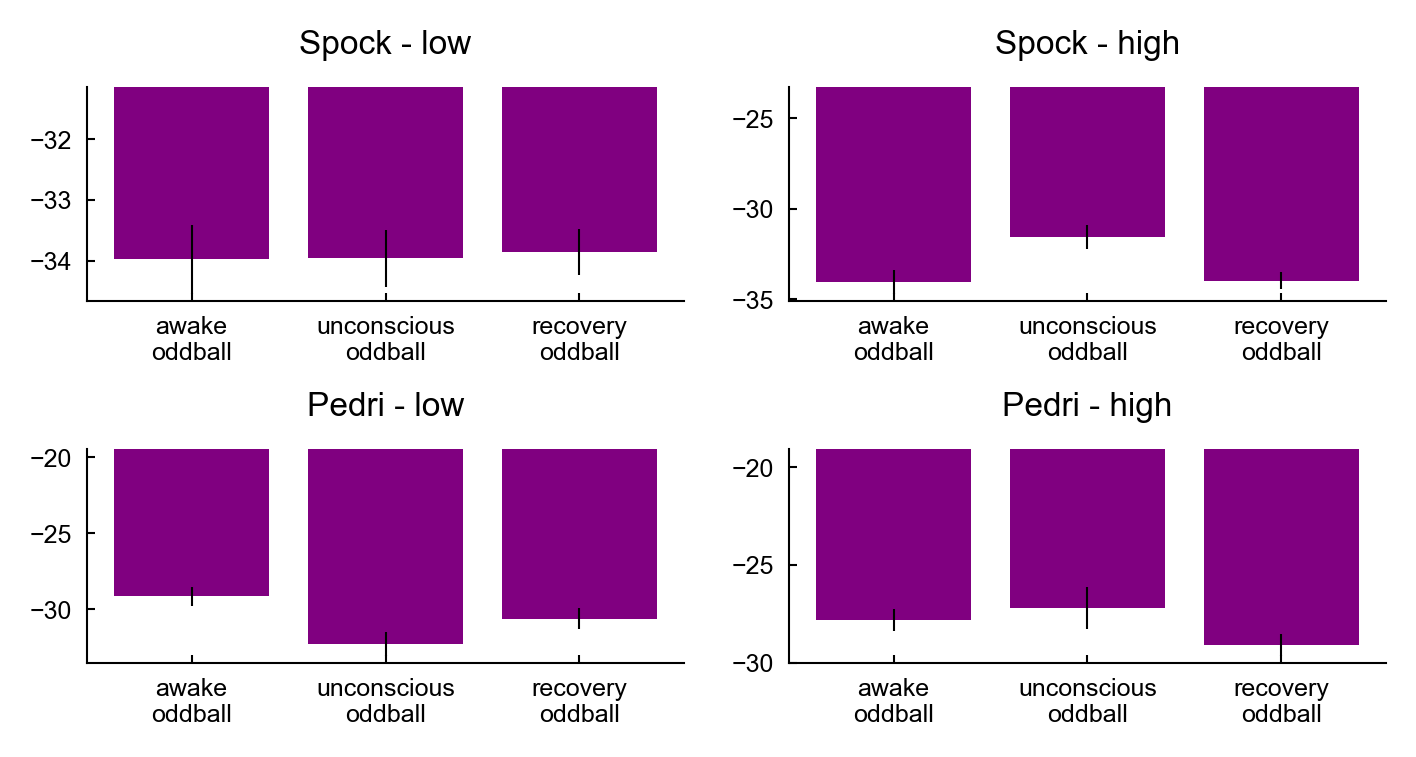

In [23]:
area_colors = {
    'all': 'purple',
    'vlPFC': 'C0',
    'dlPFC': 'C1',
    '-L': 'C2',
    '-R': 'C3',
}

area_labels = {
    'all': 'ALL',
    'vlPFC': 'vlPFC',
    'dlPFC': 'dlPFC',
    '-L': 'left-PFC',
    '-R': 'right-PFC'
}

dt_stab = 0.01
top_percent = 0.1

if 'all_sections' in cfg.params.sections_to_use:
# if True:

    stability_all = {}
    freqs_all = {}
    counts = {}

    total_its = 0
    for monkey in session_lists.keys():
        for dose in session_lists[monkey].keys():
            for area in areas:
                leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
                post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
                for session_ind, session in enumerate(session_lists[monkey][dose]):
                    filter_inds = np.logical_and(delase_results[session][area].window_start >= session_infos[session]['infusionStart'] - leadup_time*60, delase_results[session][area].window_end <= session_infos[session]['infusionStart'] + post_time*60)
                    total_its += len(delase_results[session][area][filter_inds])
    iterator = tqdm(total=total_its)

    for monkey in session_lists.keys():
        stability_all[monkey] = {}
        freqs_all[monkey] = {}
        counts[monkey] = {}
        for dose in session_lists[monkey].keys():
            stability_all[monkey][dose] = {}
            freqs_all[monkey][dose] = {}
            counts[monkey][dose] = {}
            for area in areas:

                leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
                post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
                
                stability_all[monkey][dose][area] = np.zeros((int((leadup_time + post_time)*60*(1/dt_stab)), len(session_lists[monkey][dose])), dtype=np.float32)
                freqs_all[monkey][dose][area] = np.zeros(stability_all[monkey][dose][area].shape, dtype=np.float32)
                counts[monkey][dose][area] = np.zeros(stability_all[monkey][dose][area].shape, dtype=np.int16)
            
                for session_ind, session in enumerate(session_lists[monkey][dose]):
                    filter_inds = np.logical_and(delase_results[session][area].window_start >= session_infos[session]['infusionStart'] - leadup_time*60, delase_results[session][area].window_end <= session_infos[session]['infusionStart'] + post_time*60)
                    for i, row in delase_results[session][area][filter_inds].iterrows():
                        start_ind = int(leadup_time*60/dt_stab) - int((session_infos[session]['infusionStart'] - row.window_start)/dt_stab)
                        end_ind = start_ind + int(np.ceil((row.window_end - row.window_start)/dt_stab))

                        if start_ind > len(stability_all[monkey][dose][area]):
                            print(start_ind, len(stability_all[monkey][area]))
                        # there are a few points where the time windows overlap but I decided to just
                        # overwrite the data. it's only like 7 or 8 points
                        stability_all[monkey][dose][area][start_ind:end_ind, session_ind] = row.stability_params[:int(top_percent*len(row.stability_params))].mean()
                        freqs_all[monkey][dose][area][start_ind:end_ind, session_ind] = row.stability_freqs[:int(top_percent*len(row.stability_freqs))].mean()
                        counts[monkey][dose][area][start_ind:end_ind, session_ind] = 1
                    
                        iterator.update()
    iterator.close()

    # leadup_time = 18 # minutes before anesthesia
    # post_time = 25 # minutes after anesthesia

    fig, axs = plt.subplots(2, 2, figsize=(4.7, 2.5045))

    lns = []

    for i, monkey in enumerate(session_lists.keys()):
        for j, dose in enumerate(session_lists[monkey].keys()):
            ax = axs[i][j]
            for area in stability_all[monkey][dose].keys():

                leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
                post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
                time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
                
                plot_start_time = -leadup_time + 2
                plot_end_time = post_time - 10
                time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)
                
                # raise ValueError
                mean_vals = stability_all[monkey][dose][area][time_inds].sum(axis=-1)/counts[monkey][dose][area][time_inds].sum(axis=-1)
                std_dev_vals = np.sqrt(np.square(stability_all[monkey][dose][area][time_inds] - np.expand_dims(mean_vals, -1)).sum(axis=-1)/(counts[monkey][dose][area][time_inds].sum(axis=-1) - 1))
                se_vals = std_dev_vals/np.sqrt(counts[monkey][dose][area][time_inds].sum(axis=-1))
                ax.plot(time_vals[time_inds], mean_vals, label=area_labels[area], color=area_colors[area], rasterized=True)
                
                ax.fill_between(time_vals[time_inds], mean_vals - se_vals, mean_vals + se_vals, color=area_colors[area], alpha=0.4, rasterized=True)

                ax.set_title(f"{monkey} - {dose}")

            session = session_lists[monkey][dose][0]
            section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
            ylim= ax.get_ylim()
            for _, (section_name, section_bounds) in enumerate(section_info):
                ax.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)

            ax.set_ylim([-40, -20])
    lns = []
    for area in areas:
        lns += plt.plot([], [], label=area_labels[area], color=area_colors[area])
    plt.legend(lns, [ln.get_label() for ln in lns])

    plt.tight_layout()
    plt.show()
else:
    delase_results_by_section = {}
    for i, monkey in enumerate(session_lists.keys()):
        delase_results_by_section[monkey] = {}
        for j, dose in enumerate(session_lists[monkey].keys()):
            delase_results_by_section[monkey][dose] = {}
            for session in session_lists[monkey][dose]:
                section_info = section_infos[session]
                delase_results_by_section[monkey][dose][session] = {}
                for area in areas:
                    delase_results_by_section[monkey][dose][session][area] = {}
                    
                    for section in cfg.params.sections_to_use:
                        _, section_times = section_info[[i for i, info in enumerate(section_info) if info[0] == section][0]]
                        section_times = np.array(section_times)*60 + session_infos[session]['infusionStart']
                        
                        filter_inds = np.logical_and(delase_results[session][area].window_start >= section_times[0], delase_results[session][area].window_end <= section_times[1])
                        delase_results_by_section[monkey][dose][session][area][section] = delase_results[session][area][filter_inds]
    
    collected_results = {}
    for i, monkey in enumerate(session_lists.keys()):
        collected_results[monkey] = {}
        for j, dose in enumerate(session_lists[monkey].keys()):
            collected_results[monkey][dose] = np.zeros((len(session_lists[monkey][dose]), len(areas), len(cfg.params.sections_to_use)))
            
            for k, session in enumerate(session_lists[monkey][dose]):
                for l, area in enumerate(areas):
                    for m, section in enumerate(cfg.params.sections_to_use):
                        collected_results[monkey][dose][k, l, m] = delase_results_by_section[monkey][dose][session][area][section].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).mean()

    fig, axs = plt.subplots(2, 2, figsize=(4.7, 2.5045))


    for i, monkey in enumerate(session_lists.keys()):
        for j, dose in enumerate(session_lists[monkey].keys()):
            ax = axs[i][j]
            min_val = np.inf
            max_val = -np.inf
            for l, area in enumerate(areas):
                if area == 'all':
                    mean_vals = collected_results[monkey][dose][:, l, :].mean(axis=0)
                    yerr = collected_results[monkey][dose][:, l].std(axis=0)/np.sqrt(len(session_lists[monkey][dose]))
                    # if monkey == 'Spock' and dose == 'high':
                    #     raise ValueError
                    ax.bar(['\n'.join(section.split(' ')) for section in cfg.params.sections_to_use], mean_vals, yerr=yerr, label=area_labels[area], color=area_colors[area], rasterized=True)
                    
                    ax.set_title(f"{monkey} - {dose}")

                    if (mean_vals - yerr).min() < min_val:
                        min_val = (mean_vals - yerr).min()
                    if (mean_vals + yerr).max() > max_val:
                        max_val = (mean_vals + yerr).max()
            ax.set_ylim([min_val - (max_val - min_val)*0.1, max_val + (max_val - min_val)*2])

    plt.tight_layout()
    plt.show()
                    

In [24]:
from scipy.stats import wilcoxon

In [25]:
monkey = 'Pedri'
dose = 'high'
wilcoxon(collected_results[monkey][dose][:, 0, 0], collected_results[monkey][dose][:, 0, 1], alternative='less')

WilcoxonResult(statistic=np.float64(14.0), pvalue=np.float64(0.3203125))

In [26]:
mean_vals

array([-27.79845095, -27.2034297 , -29.09946942])

# Look at data

In [33]:
monkey = 'Pedri'
dose = 'high'

In [35]:
for session_ind, session in enumerate(session_lists[monkey][dose]):
    leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
    post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
    # time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
    
    if session_ind == 4:
        break

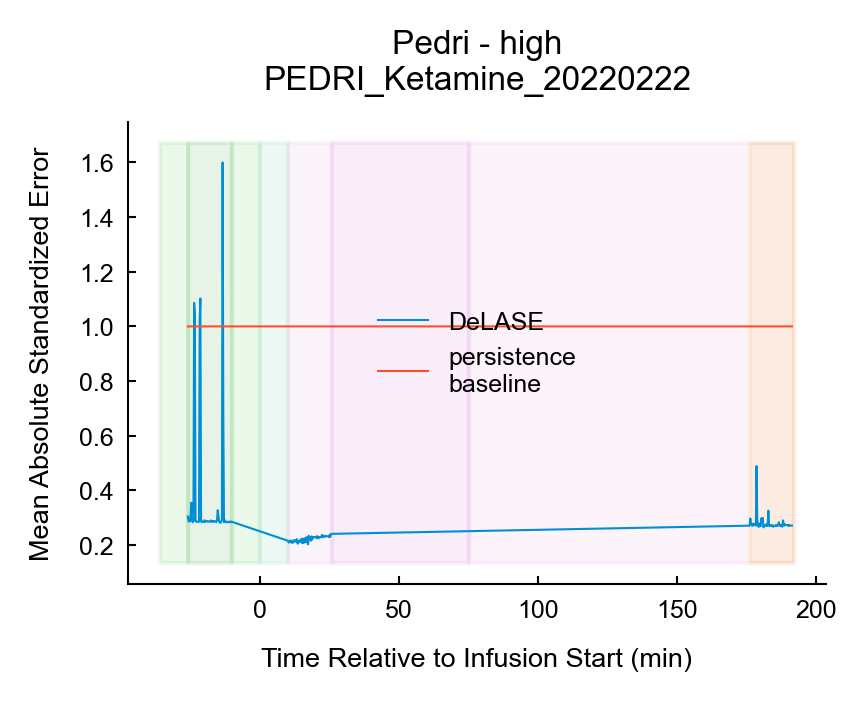

In [36]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
for area in areas:
# for area in ['vlPFC']:
    plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val, label='DeLASE')
    plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val_pb, label='persistence\nbaseline')
    # plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val_VAR)
ylim= plt.ylim()
for i, (section_name, section_bounds) in enumerate(section_info):
    plt.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)

plt.ylabel('Mean Absolute Standardized Error')
plt.xlabel('Time Relative to Infusion Start (min)')
plt.title(f"{monkey} - {dose}\n{session}")
# plt.plot(delase_results[session][area].mase_val_VAR_small)
plt.legend()
plt.show()

In [37]:
directory_path = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, session + '_lfp_chunked_20s', 'directory')
directory = pd.read_pickle(directory_path)

In [38]:
# row_ind = delase_results[session][area].mase_val.to_numpy().argmax()
row_ind = np.argsort(delase_results[session][area].mase_val.to_numpy())[-1]
# row_ind = 8
row_max_mase = delase_results[session][area].iloc[row_ind]

In [39]:
# lfp = load_window_from_chunks(row_max_mase.window_start, row_max_mase.window_end, directory)
# lfp_test = load_window_from_chunks(row_max_mase.test_window_start, row_max_mase.test_window_end, directory)
lfp_both = load_window_from_chunks(row_max_mase.window_start, row_max_mase.test_window_end, directory)

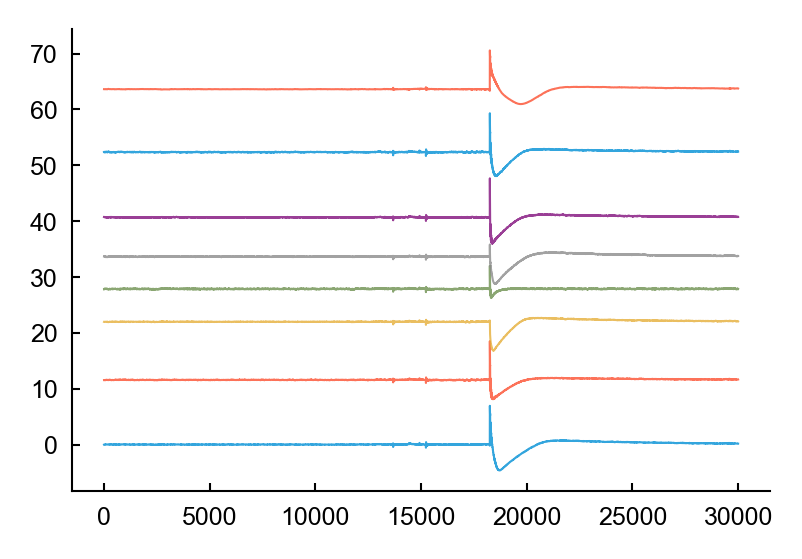

In [40]:
offset = 0
for i in range(0, lfp_both.shape[1], 16):
    plt.plot(lfp_both[:, i] + offset, alpha=0.8)
    offset += (lfp_both[:, i][lfp_both[:, i] > 0].max() + np.abs(lfp_both[:, i][lfp_both[:, i] < 0].min()))
# plt.plot(lfp[:, 0])

In [41]:
corr_mat = np.corrcoef(lfp_both.T)

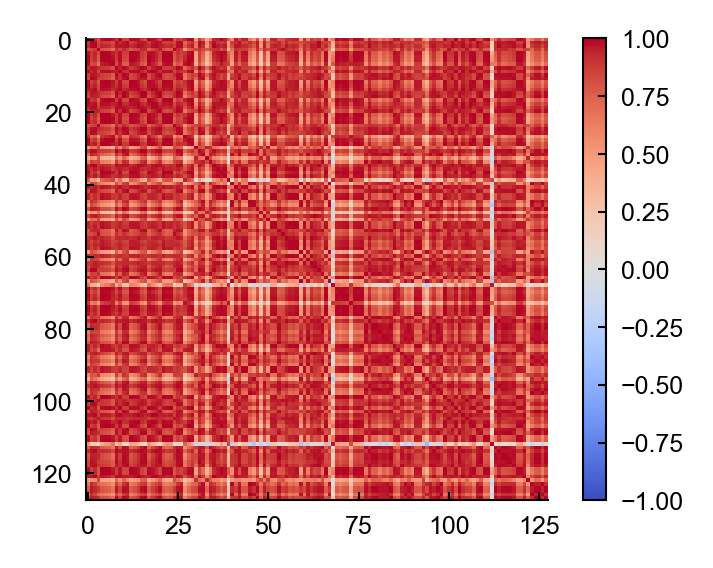

In [42]:
norm = Normalize(vmin=-1, vmax=1)
plt.imshow(corr_mat, norm=norm, cmap='coolwarm')
plt.colorbar()
plt.show()

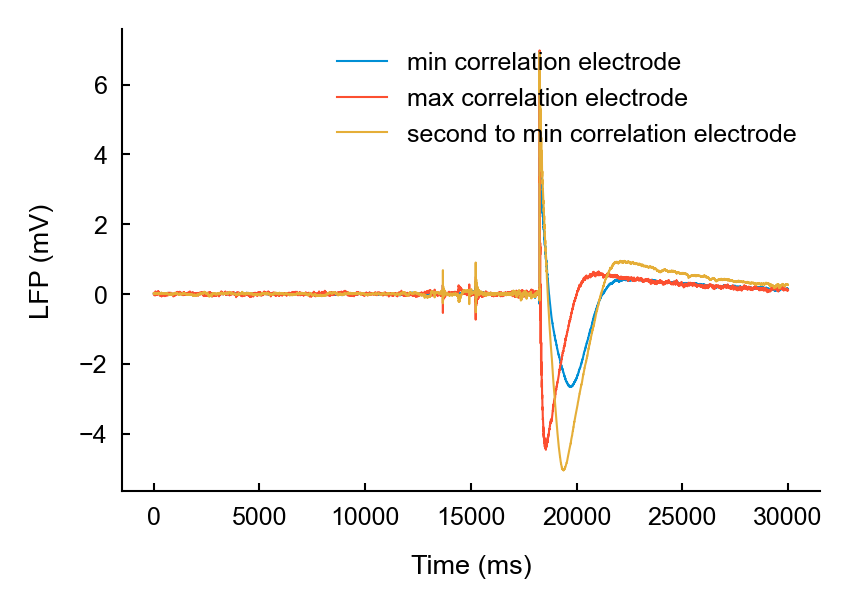

In [43]:
min_corr_ind = corr_mat.mean(axis=1).argmin()
second_to_min_corr_ind = np.argsort(corr_mat.mean(axis=1))[1]
max_corr_ind = corr_mat.mean(axis=1).argmax()

plt.plot(lfp_both[:, min_corr_ind], label='min correlation electrode')
plt.plot(lfp_both[:, max_corr_ind], label='max correlation electrode')
plt.plot(lfp_both[:, second_to_min_corr_ind], label='second to min correlation electrode')
plt.xlabel('Time (ms)')
plt.ylabel('LFP (mV)')
plt.legend()
plt.show()

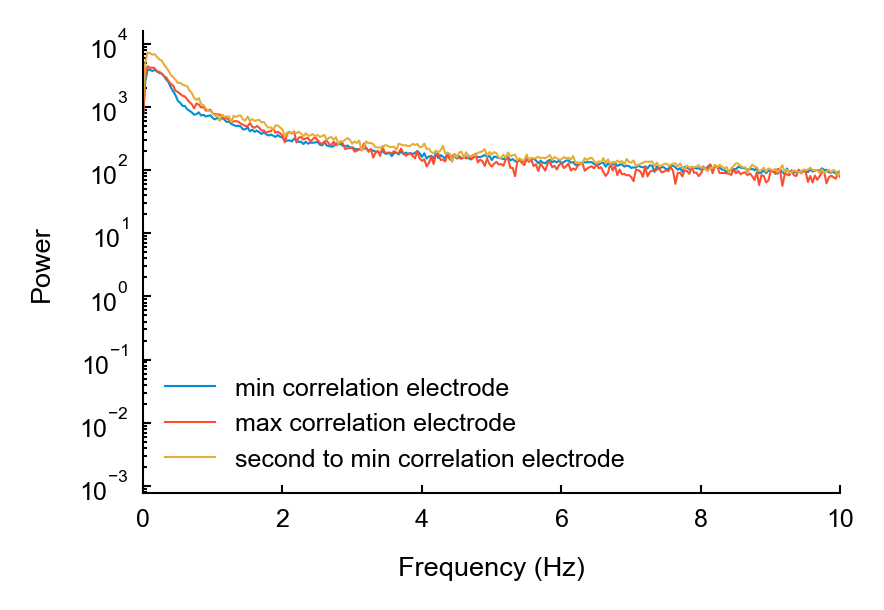

In [44]:
fft_vals = np.fft.rfft(lfp_both, axis=0)
fft_freq = np.fft.rfftfreq(lfp_both.shape[0], d=dt)

plt.plot(fft_freq, np.abs(fft_vals[:, min_corr_ind]), label='min correlation electrode')
plt.plot(fft_freq, np.abs(fft_vals[:, max_corr_ind]), label='max correlation electrode')
plt.plot(fft_freq, np.abs(fft_vals[:, second_to_min_corr_ind]), label='second to min correlation electrode')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.yscale('log')
plt.xlim([0, 10])
plt.legend()
plt.show()

In [62]:
variables = ['electrodeInfo']
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
electrode_info = session_vars['electrodeInfo']

In [63]:
lfp_all = load_window_from_chunks(0, T*dt, directory)
avg_std_dev = lfp_all.std(axis=0).mean()

In [64]:
std_dev_mult = 5
bad_electrodes = []
worst_electrode_example = []
window = 15
window_starts = np.arange(0, T*dt - window, window)
for window_start in tqdm(window_starts):
    window_end = window_start + window
    lfp_vals = load_window_from_chunks(window_start, window_end, directory)
    bad_electrodes.append(np.sum(np.abs(lfp_vals).max(axis=0) > avg_std_dev*std_dev_mult))
    worst_electrode_example.append(lfp_vals[:, np.argmax(lfp_vals.max(axis=0))])

  0%|          | 0/913 [00:00<?, ?it/s]

In [78]:
# bad_electrodes = []
# worst_electrode_example = []
# for row in tqdm(delase_results[session][area].itertuples(), total=len(delase_results[session][area])):
#     lfp_vals = load_window_from_chunks(row.window_start, row.test_window_end, directory)
#     bad_electrodes.append(np.sum(lfp_vals.max(axis=0) > avg_std_dev*5))
#     worst_electrode_example.append(lfp_vals[:, np.argmax(lfp_vals.max(axis=0))])

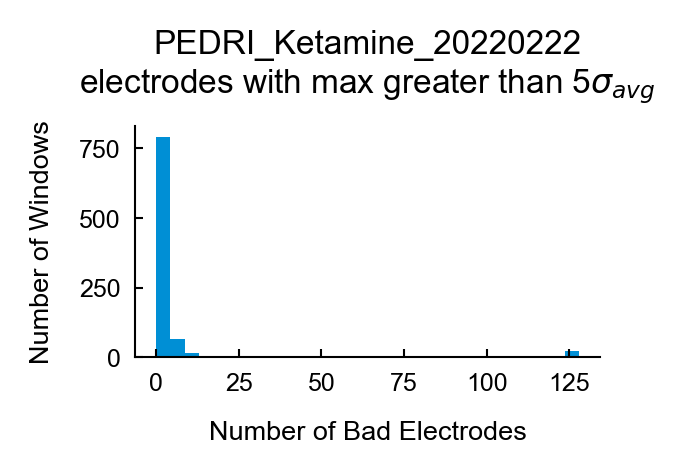

In [65]:
plt.figure(figsize=(2, 1))
plt.hist(bad_electrodes, bins=30)
plt.xlabel('Number of Bad Electrodes')
plt.ylabel('Number of Windows')
plt.title(f"{session}\nelectrodes with max greater than {std_dev_mult}" + r"$\sigma_{avg}$")
plt.show()

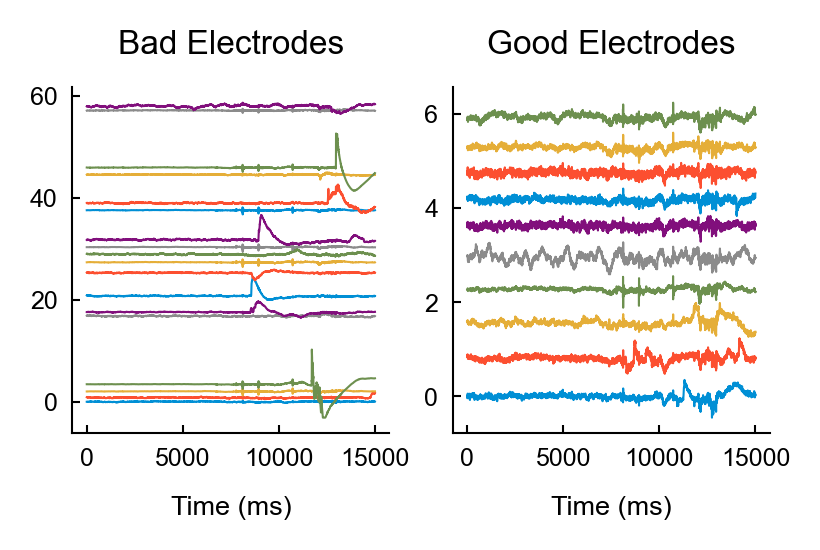

In [71]:
bad_electrode_indices = [i for i, num_bad in enumerate(bad_electrodes) if num_bad > 0 ]

# bad_elec_ind = 0
# window_ind = bad_electrode_indices[bad_elec_ind]

window_ind = int(np.argmax(np.array(bad_electrodes) > 2))


lfp_vals = load_window_from_chunks(window_starts[window_ind], window_starts[window_ind] + window, directory)
max_vals = np.abs(lfp_vals).max(axis=0)
sorted_inds = np.argsort(max_vals)
bad_boolean = max_vals > std_dev_mult*avg_std_dev
plt.figure(figsize=(3, 1.5))
plt.subplot(1, 2, 1)
offset = 0
for i in np.where(bad_boolean)[0]:
    plt.plot(lfp_vals[:, i] + offset)
    offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Bad Electrodes')
plt.xlabel('Time (ms)')
plt.subplot(1, 2, 2)
offset = 0
for i in sorted_inds[:-np.sum(bad_boolean)][::-1][:10]:
    plt.plot(lfp_vals[:, i] + offset)
    offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Good Electrodes')
plt.xlabel('Time (ms)')
plt.show()

# Reanalyze?

In [71]:
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables=['electrodeInfo'], data_class=cfg.params.data_class, verbose=False)

In [72]:
electrode_info = session_vars['electrodeInfo']

In [73]:
awake_oddball_times = section_info[1][1]
unconscious_oddball_times = section_info[4][1]

In [597]:
len(np.where(['vlPFC' in area for area in electrode_info['area']])[0])

64

In [83]:
np.random.seed(43)
t_a = np.random.uniform(awake_oddball_times[0], awake_oddball_times[1])*60 + session_infos[session]['infusionStart']
t_u = np.random.uniform(unconscious_oddball_times[0], unconscious_oddball_times[1])*60 + session_infos[session]['infusionStart']
# lfp_a = load_window_from_chunks(t_a, t_a + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])
# lfp_u = load_window_from_chunks(t_u, t_u + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])

window = 30

lfp_a = load_window_from_chunks(t_a, t_a + window, directory)
lfp_u = load_window_from_chunks(t_u, t_u + window, directory)

In [88]:
# n_delays, rank = grid_search_results[session][area]['n_delays'], grid_search_results[session][area]['rank']
n_delays, rank = 10, 850

In [89]:
delase_a = DeLASE(lfp_a, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_a.fit()
delase_u = DeLASE(lfp_u, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_u.fit()

In [90]:
top_percent = 0.1

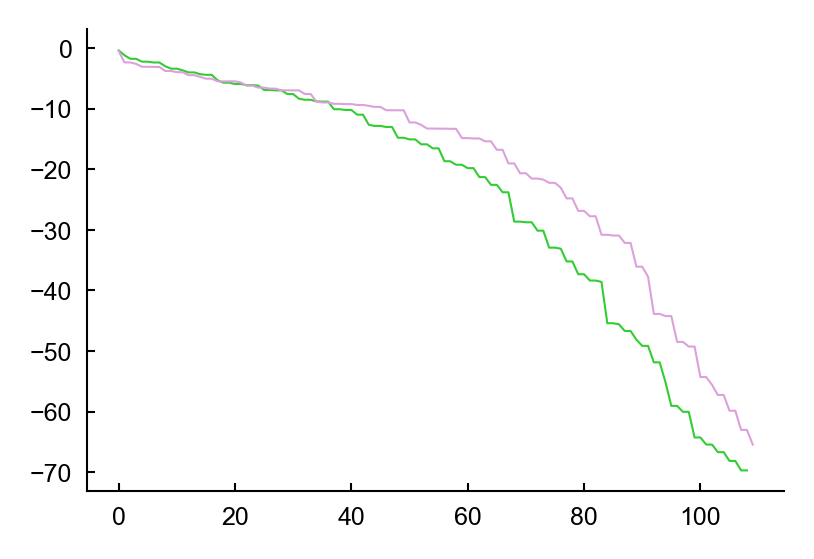

In [91]:
plt.plot(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), c='limegreen')
plt.plot(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), c='plum')

In [609]:
# plt.scatter(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), delase_a.stability_freqs[:int(top_percent*len(delase_a.stability_freqs))].cpu(), s=4, c='limegreen')
# plt.scatter(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), delase_u.stability_freqs[:int(top_percent*len(delase_u.stability_freqs))].cpu(), s=4, c='plum')
# # plt.scatter(stab_param2[:int(top_percent*len(stab_param1))], stab_freq2[:int(top_percent*len(stab_param1))], s=4)

In [610]:
delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu().mean(), delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu().mean()

(tensor(-19.5074), tensor(-19.9633))

In [611]:
mannwhitneyu(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), alternative='less')

MannwhitneyuResult(statistic=np.float64(3266.0), pvalue=np.float64(0.6941822488196869))

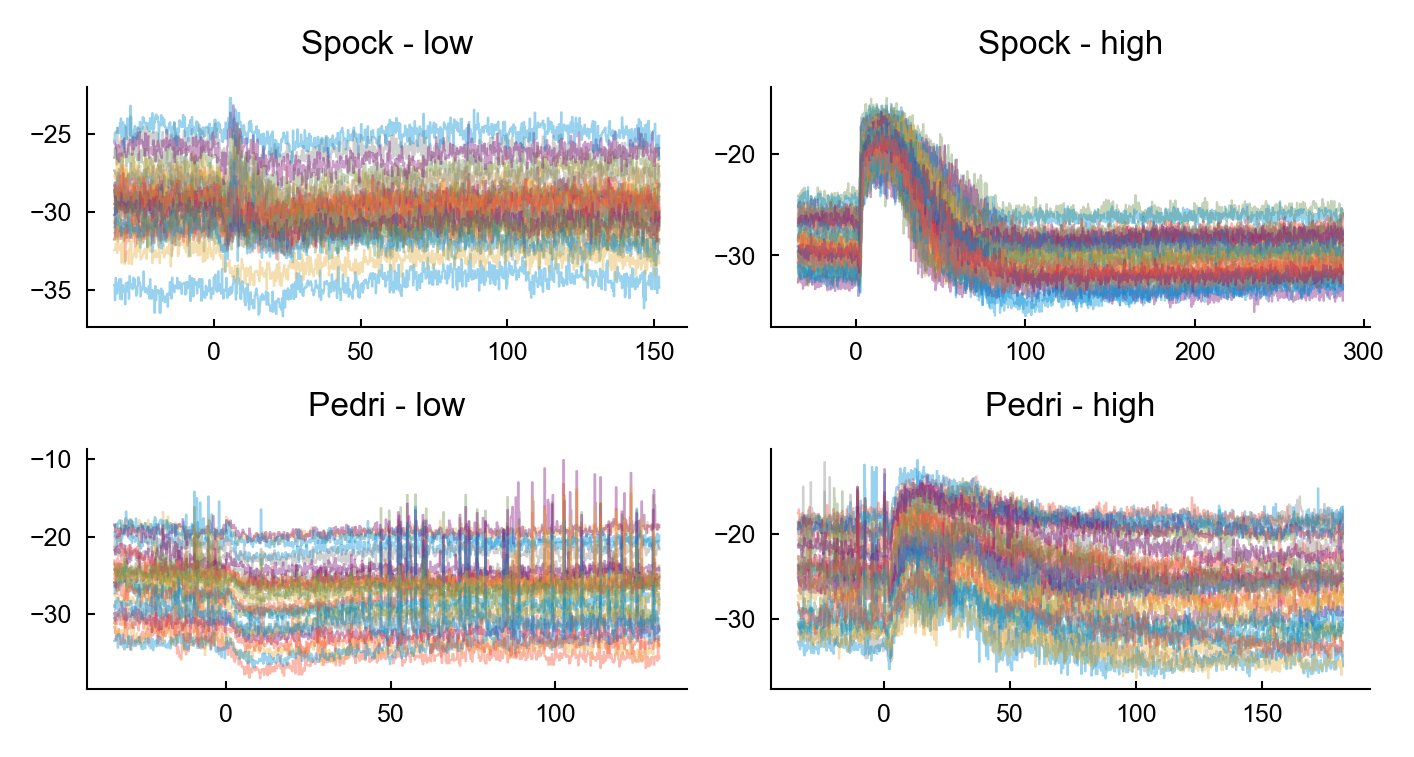

In [38]:
# leadup_time = 18 # minutes before anesthesia
# post_time = 25 # minutes after anesthesia

fig, axs = plt.subplots(2, 2, figsize=(4.7, 2.5045))

lns = []

for i, monkey in enumerate(session_lists.keys()):
    for j, dose in enumerate(session_lists[monkey].keys()):
        ax = axs[i][j]
        for area in stability_all[monkey][dose].keys():

            leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60

            time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
            plot_start_time = -leadup_time + 2
            plot_end_time = post_time - 10
            time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

            for session_ind in range(stability_all[monkey][dose][area].shape[-1]):
                ax.plot(time_vals[time_inds], stability_all[monkey][dose][area][time_inds, session_ind], label=area_labels[area], rasterized=True, alpha=0.4)

            ax.set_title(f"{monkey} - {dose}")

plt.tight_layout()
plt.show()

In [120]:
for monkey in session_lists.keys():
    for dose in session_lists[monkey].keys():
        print("-"*10)
        print(f"{monkey} - {dose}")
        for session in session_lists[monkey][dose]:
            print((grid_search_results[session][area]['n_delays'], grid_search_results[session][area]['rank']))

----------
Spock - low
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
----------
Spock - high
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
----------
Pedri - low
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
----------
Pedri - high
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)


In [37]:
variables = ['sessionInfo']
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
session_info = session_vars['sessionInfo']
if 'propofol' in cfg.params.data_class:
    drug_start = session_info['drugStart'][0]
elif 'lever' in cfg.params.data_class:
    drug_start = session_info['infusionStart']

In [38]:
for area in areas:
    break

In [39]:
results_df = delase_results[session][area]

In [40]:
top_percent = 0.1

In [41]:
mean_stab = results_df.stability_params.apply(lambda x: x[:int(len(x)*top_percent)].mean())

In [42]:
time_vals = results_df.window_start/60 - drug_start/60

In [43]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

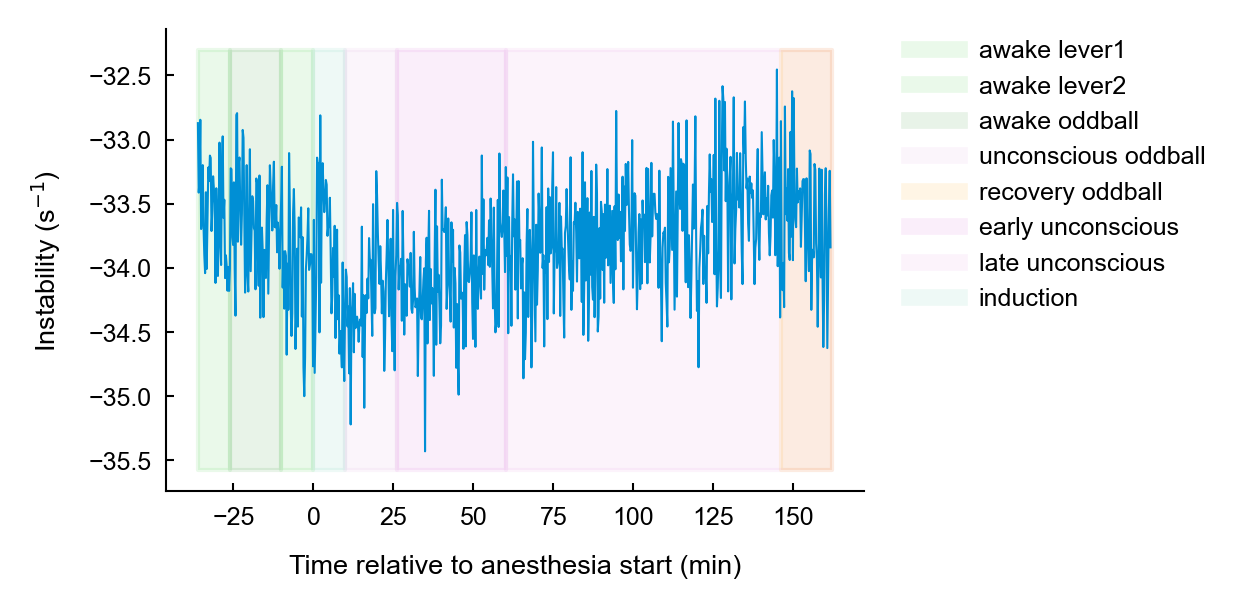

In [44]:
plt.plot(time_vals, mean_stab)
ylim = plt.ylim()

# def adjust_text_positions(section_info, ylim):
#     text_y_pos = []
#     for i, (_, section_bounds) in enumerate(section_info):
#         if i == 0:
#             y_pos = ylim[-1] + (ylim[-1] - ylim[0]) * 0.05
#         else:
#             y_pos = text_y_pos[-1] + (ylim[-1] - ylim[0]) * 0.1
#         text_y_pos.append(y_pos)
#     return text_y_pos

# text_y_pos = adjust_text_positions(section_info, ylim)

# # text_y_pos = np.linspace(ylim[-1] + (ylim[-1] - ylim[0])*0.05, ylim[-1] + (ylim[-1] - ylim[0])*0.2, len(section_info))
for i, (section_name, section_bounds) in enumerate(section_info):
    plt.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)
#     # plt.text(np.mean(section_bounds), ylim[-1] + (ylim[-1] - ylim[0])*0.05, '\n'.join(section_name.split(' ')), color=section_colors[section_name], ha='center', va='center')
#     plt.text(np.mean(section_bounds), text_y_pos[i], '\n'.join(section_name.split(' ')), color=section_colors[section_name], ha='center', va='center')
# plt.xlim([time_vals[0], 180])
plt.xlabel('Time relative to anesthesia start (min)')
plt.ylabel('Instability (s$^{-1}$)')

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4, alpha=0.1) for color in section_colors.values()]
plt.legend(legend_handles, section_colors.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.show()